# Implementing Annealing from Foundations

#### Last Time
[Previously](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/04_callbacks_my_reimplementation.ipynb?flush_cache=true) we implemented a home-grown callback system for our training loop from scratch. We created a `Runner()` class that encapsulates all stages of a model training loop, and allows for callbacks to be wired in at any stage if desired.

We also created two basic callbacks:
1. Switching model training mode between train and eval, depending on whether or not inference is being performed.
* Calculating and displaying avg loss & evaluation metrics while training.

#### Annealing
We had also mentioned that callbacks could be used to adjust hyperparameter values on-the-fly during training. In this notebook we demonstrate how to create a scheduler callback that will gradually adjust the learning rate according during the training cycle. This process is also known as "annealing" the learning rate. 

Typically, the rate of annealing is governed by a particular mathematical function. In our case, we use cosine annealing, which will gradually increase and then decrease the learning rate during training, at a rate that follows a cosine curve. 

#### Attribution
Virtually all the code that appears in this notebook is the creation of [Sylvain Gugger](https://www.fast.ai/about/#sylvain) and [Jeremy Howard](https://www.fast.ai/about/#jeremy). The original version of this notebook that they made for the course lecture can be found [here](https://github.com/fastai/course-v3/blob/master/nbs/dl2/05_anneal.ipynb). I simply re-typed, line-by-line, the pieces of logic necessary to implement the functionality that their notebook demonstrated. In some cases I changed the order of code cells and or variable names so as to fit an organization and style that seemed more intuitive to me. Any and all mistakes are my own.

On the other hand, all long-form text explanations in this notebook are solely my own creation. Writing extensive descriptions of the concepts and code in plain and simple English forces me to make sure that I actually understand how they work.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#export
from exports.nb_04 import *

### Initial Setup
Let's grab our dataset (still using [MNIST](http://yann.lecun.com/exdb/mnist/index.html)) and setup our model. Notice that thanks to the work we've done in previous notebooks, we're getting to the point where we're able to do this in fewer and fewer lines of code:

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

We can define a convenience method that'll return the `Learner` object containing our model, its hyperparameters, loss function, and data:

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

As specified in our previous notebook, `Runner` objects contain the training loop logic as well as points to wire in any callbacks we create.

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

In [7]:
run.fit(3, learn)

train: [0.666904765625, tensor(0.8054)]
valid: [0.303007177734375, tensor(0.9129)]
train: [0.2925882421875, tensor(0.9162)]
valid: [0.23477666015625, tensor(0.9326)]
train: [0.2372396484375, tensor(0.9305)]
valid: [0.2111236083984375, tensor(0.9388)]


Note that by using `partial()` to wrap the `get_model()` method we can pass a specific value for learning rate:

In [8]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

In [9]:
run.fit(3, learn)

train: [0.7773809375, tensor(0.7930)]
valid: [0.347355712890625, tensor(0.9018)]
train: [0.350820546875, tensor(0.8984)]
valid: [0.288727783203125, tensor(0.9167)]
train: [0.29534150390625, tensor(0.9143)]
valid: [0.2618358642578125, tensor(0.9228)]


Why don't we make our API a bit more user friendly by saving users from having to remember to use `partial()` to pass a learning rate value:

In [10]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

### Annealing

Annealing is just the adjustment of a hyperparameter, such as learning rate, over the course of an epoch's iterations. In order to support this, we will implement a `ParamScheduler` callback class which will be able to schedule any hyperparameter that is registered in the `state_dict` of the optimizer.

In [11]:
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): 
        self.pname, self.sched_func = pname, sched_func
        
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param()

Let's also create a `Recorder` callback class. It'll record both the loss and learning rate during training and allow us to plot both. This will be useful for verifying that our learning rate is annealing at the rate we desire.

In [12]:
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []
    
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

We'll start by implementing a simple linear scheduler. This will allow us to verify that the above implementations are working as intended.

This linear scheduler returns a function that takes a `pos` argument (the x-axis value) which will be fed into the function from a pre-defined range.

`start` is the y-axis value at the earliest `pos` (the first x-axis value), and `end` is the y-axis value at the final `pos` (the last x-axis value).

The math, which in the linear schedule is defined in the line: `start + pos*(end-start)` determines how the y-axis value changes as `pos` moves from the beginning of the x-axis range to the end of the x-axis range.

In [13]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [14]:
f = sched_lin(1,2)
f(0.3)

1.3

In [15]:
sched = sched_lin(1,2)

cbfs = [Recorder, 
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs = cbfs)

In [16]:
run.fit(3, learn)

train: [0.729876171875, tensor(0.7612)]
valid: [0.323570751953125, tensor(0.8909)]
train: [0.25393265625, tensor(0.9226)]
valid: [0.2395525146484375, tensor(0.9220)]
train: [0.386031953125, tensor(0.8856)]
valid: [0.2268899169921875, tensor(0.9346)]


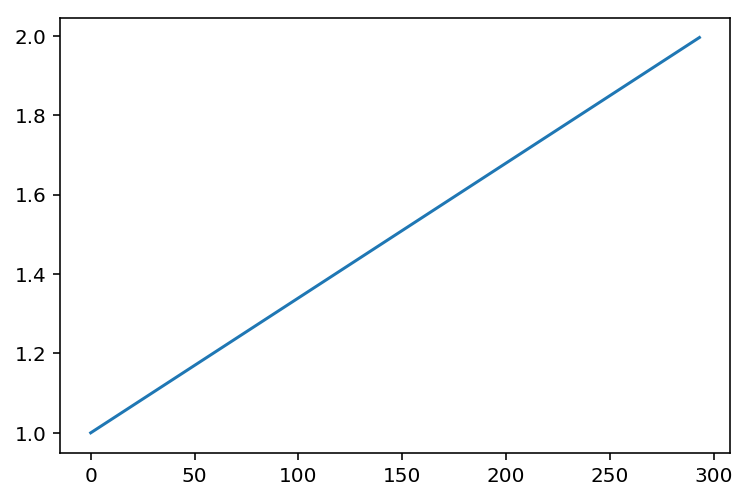

In [17]:
run.recorder.plot_lr()

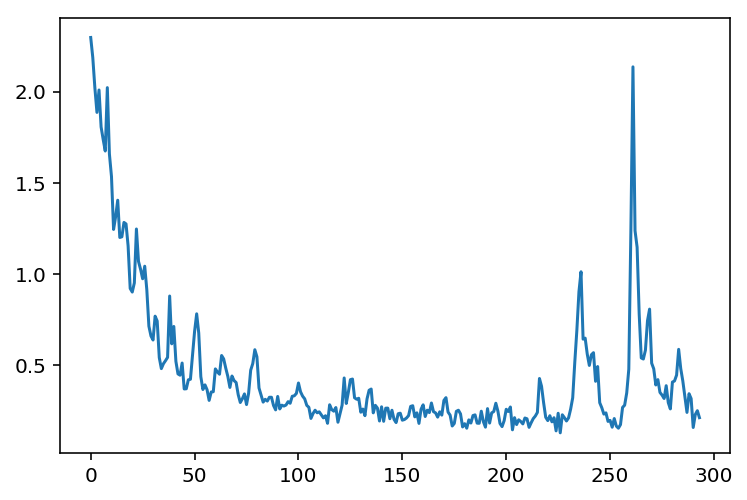

In [18]:
run.recorder.plot_loss()

Everything looks good. Since our main goal is to use cosine annealing it's time to implement a cosine scheduler. However, notice that it was kind of a hassle to have to define a nested `_inner()` method inside linear scheduling `sched_lin()` method we created above.

It would be nicer if we could define new scheduler functions just by specifying the math, and not having to remember to create that nested `_inner` method and return it inside a `partial()` call.

Creating an `@annealer` decorator will accomplish just that! We can define the necessary messy stuff just once, and never have to worry about it again:

In [19]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [20]:
f = sched_lin(1,2)
f(0.3)

1.3

We'll create three more schedulers: cosine, exponential, and a scheduler that keeps a hyperparameter constant:

In [21]:
#export
@annealer
def sched_cos(start, end, pos): 
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def sched_exp(start, end, pos):
    return start * (end/start) ** pos

@annealer
def sched_none(start, end, pos): return start

Unfortunately, we're gonna need a monkey-patch in order to be able to plot tensors:

In [22]:
torch.Tensor.ndim = property(lambda x: len(x.shape))

Let's plot each of the schedules we just defined:

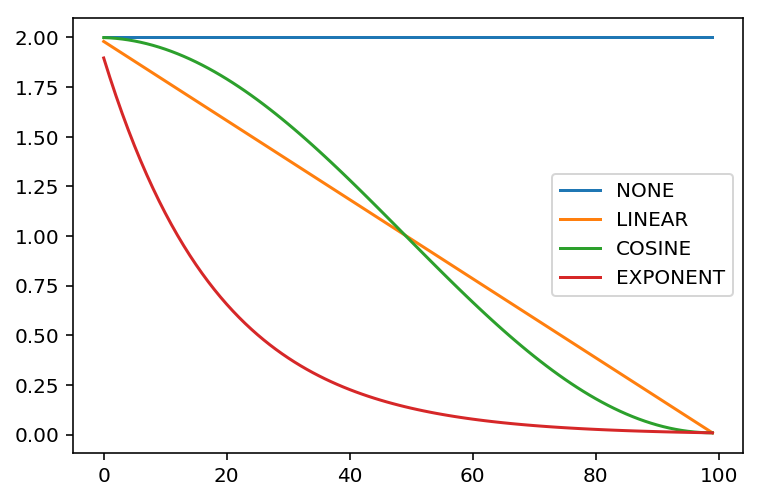

In [23]:
annealings = "NONE LINEAR COSINE EXPONENT".split()

x_range = torch.arange(0, 100)
pos = torch.linspace(0.01,1,100)

fns = [sched_none, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(x_range, [f(o) for o in pos], label=t)
plt.legend();

#### `combine_scheds()`
In practice we generally wish to combine different schedulers. Learning rate is often warmed-up and then cooled-down during a training cycle. To implement this we'd want to have one cosine schedule that gradually increases learning rate during the early portion of a learning cycle, and then have a second cosine scheduler that gradually decreases learning rate during the remainder of the learning cycle.

Here's a method that'll allow us to do just that:

In [24]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1] - pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

This method takes two lists as arguments. The first list contains percentages that comprise the desired segments of the learning cycle. Say we want to combine two different schedulers and have the first one run for the first 30% of the cycle and have the second scheduler run for the final 70%: we'd pass the list `[0.3, 0.7]` to our `pcts` parameter.

Here's what the method then does to that list:

In [25]:
pcts = [0.3, 0.7]
pcts = tensor([0] + listify(pcts))
pcts

tensor([0.0000, 0.3000, 0.7000])

In [26]:
torch.cumsum(pcts, 0)

tensor([0.0000, 0.3000, 1.0000])

The `_inner()` method determines, at any given x-axis value, which scheduler should be used, and then use that scheduler to calculate the hyperparameter value. 

For example, say we're currently one-fourth of the way through (at position `0.25`) our learning cycle:

In [27]:
pos = 0.25
idx = (pos >= pcts).nonzero().max()
idx

tensor(0)

In [28]:
actual_pos = (pos-pcts[idx]) / (pcts[idx+1] - pcts[idx])
actual_pos

tensor(0.8333)

`_inner()` determines that we should still be using the first scheduler (`idx` = 0) since our position is less than one-third of the way through the learning cycle.

`_inner()` then goes on to calculate the actual position (x-axis value) that should be fed into the scheduler so that it can output the appropriate hyperparameter value.

Here's a full-fledged example where we will use cosine annealing to both increase the learning rate from 0.3 to 0.6 during the first 30% of the training cycle, and then decrease the learning rate from 0.6 down to 0.2 during the remaining 70% of the cycle.

In [29]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

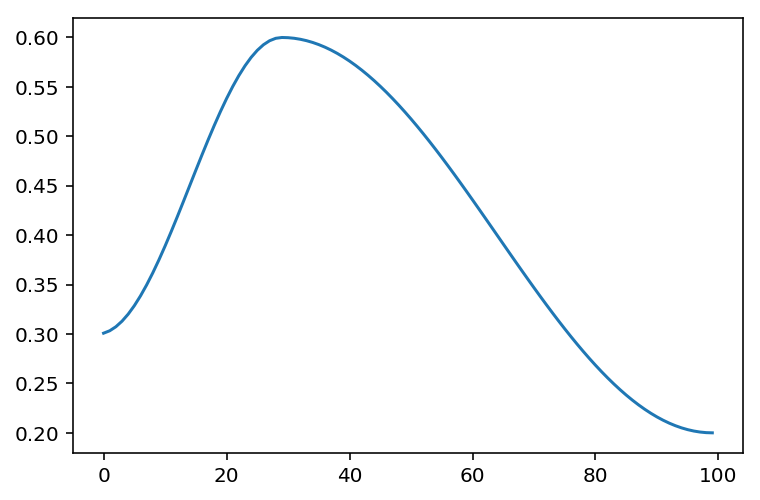

In [30]:
x_range = torch.arange(0, 100)
pos = torch.linspace(0.01,1,100)

plt.plot(x_range, [sched(o) for o in pos]);

Let's train a model using this scheduler:

In [31]:
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        partial(ParamScheduler, 'lr', sched)]

learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [32]:
run.fit(3, learn)

train: [0.79221375, tensor(0.7832)]
valid: [0.3035840087890625, tensor(0.9167)]
train: [0.2990459375, tensor(0.9136)]
valid: [0.2469872314453125, tensor(0.9316)]
train: [0.23684009765625, tensor(0.9324)]
valid: [0.211227734375, tensor(0.9406)]


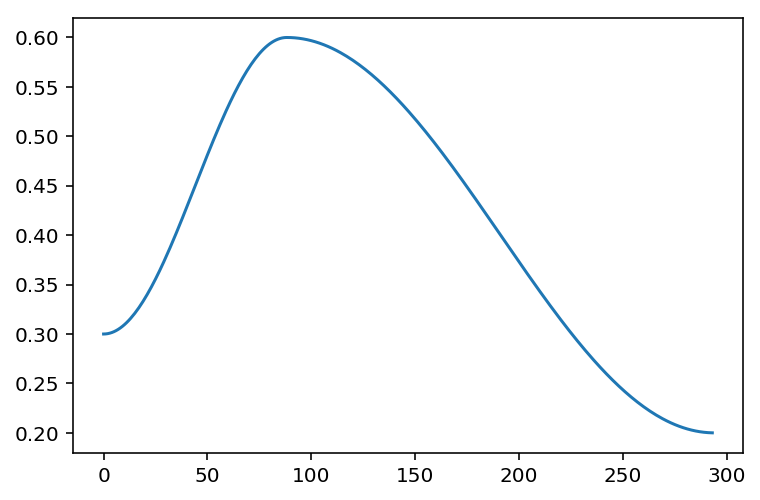

In [33]:
run.recorder.plot_lr()

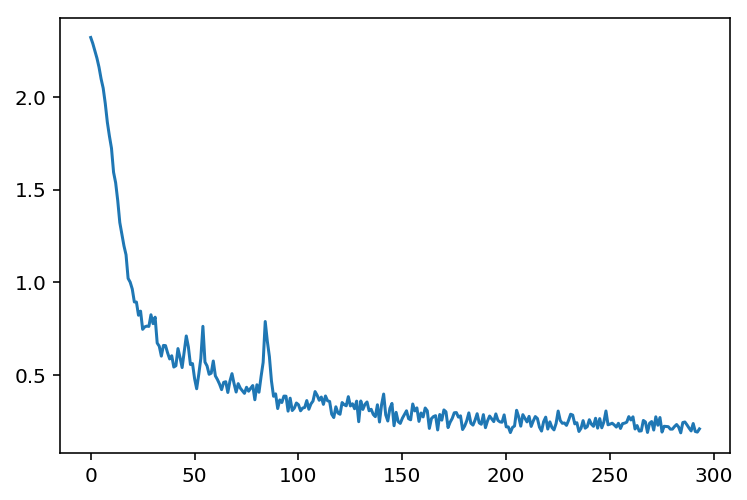

In [34]:
run.recorder.plot_loss()

Encouragingly, we notice that using this combined cosine annealing schedule for learning rate enables us to get a much improved loss over three epochs of training, in comparison to using the simple linear annealing we did at first.

### Discriminative Learning Rates

Sometimes we want to use different learning rates to train the weights at different layers of our deep networks. While other times we may desire to train  network's weights and biases and different learning rates. Because PyTorch optimizers support grouping a  network's parameters into a list dictionaries that contain the weight values for each group we define, we can rewrite our `ParamScheduler` class to schedule a list of learning rates, where each learning rate corresponds to a particular group in the optimizer's list of parameter groups. 

In [35]:
#export
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs = pname, sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            # Apply same sched func to each param group if only one 
            # sched func is passed.
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
            
    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        # If list of sched funcs is passed, apply each sched func 
        # corresponding pram group
        for pg,f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param()

We also need to update our `Recorder` callback class to keep track of each learning rate we schedule:

In [36]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []
        
    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, slip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])

Now let's train a model that makes use of discriminative learning rates. We'll create a model and then create two dictionaries, one will contain the weights of the model's layers, and the other will have all the biases.

In [37]:
m = data.train_ds.x.shape[1]
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, data.c))

In [38]:
wgts,biases = [], []

for l in model:
    if hasattr(l, 'weight'): wgts  .append(l.weight)
    if hasattr(l, 'bias'  ): biases.append(l.bias  )

In [39]:
#export
def pg_dicts(pgs): return [{'params': o} for o in pgs]

We've now created parameter group dictionaries for the weights and biases of our network. The list containing these dictionaries is passed as an argument to PyTorch's `optim.SGD` optimizer.

In [40]:
pgs = pg_dicts((wgts, biases))

In [41]:
opt = optim.SGD(pgs, lr=0.1)
learn = Learner(model, opt, loss_func, data)

The dual-scheduler cosine annealer that we tried out earlier should look very familiar -- it's similar to how the [one-cycle](https://arxiv.org/pdf/1803.09820.pdf) learning rate scheduler is [implemented](https://docs.fast.ai/callbacks.one_cycle.html#OneCycleScheduler) in version 1.0 of the fastai library.

In [42]:
#export
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [43]:
phases = [0.3, 0.7]
sched_w = combine_scheds(phases, cos_1cycle_anneal(0.3, 0.6, 0.2))
sched_b = combine_scheds(phases, cos_1cycle_anneal(0.9, 1.8, 0.6))

We'll design a method that will assemble and return a list containing schedulers for as many parameter groups as we may have:

In [44]:
def create_scheds(pct_first, sched_func, starts, highs, ends):
    phases = [pct_first, 1-pct_first]
    return [
        combine_scheds(phases, [sched_func(s,h), sched_func(h,e)]) for 
        s,h,e in zip(starts,highs,ends)
    ]

In [45]:
scheds = create_scheds(0.3, sched_cos, (0.3,0.9), (0.6,1.8), (0.2,0.6))

cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', scheds)]

run = Runner(cb_funcs=cbfs)

In [46]:
run.fit(3, learn)

train: [0.798213515625, tensor(0.7811)]
valid: [0.336452978515625, tensor(0.9001)]
train: [0.3080628515625, tensor(0.9084)]
valid: [0.2385373291015625, tensor(0.9316)]
train: [0.24252240234375, tensor(0.9294)]
valid: [0.2179073486328125, tensor(0.9385)]


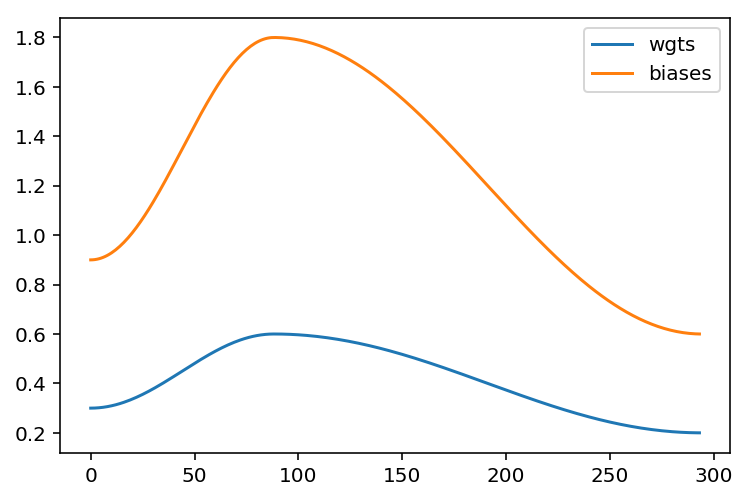

In [47]:
plt.plot(run.recorder.lrs[0])
plt.plot(run.recorder.lrs[1])
plt.legend(['wgts', 'biases']);

### Export

In [48]:
!python notebook2script_my_reimplementation.py 05_anneal_my_reimplementation.ipynb

Converted 05_anneal_my_reimplementation.ipynb to nb_05.py
